https://www.kaggle.com/c/titanic

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics

In [3]:
sns.set_style()
pd.options.display.notebook_repr_html = False
pd.options.display.max_rows = 20

In [4]:
train = pd.read_csv('train.csv', header=0)
test = pd.read_csv('test.csv', header=0)

In [5]:
def predictions_export(predicted_labels, file_name):
    """Prediction's export to .csv. Kaggle compliant format."""
    result_df = pd.read_csv('test.csv', usecols=['PassengerId'], header=0)
    result_df['Survived'] = predicted_labels.astype(int)
    result_df.to_csv(file_name, index=False)
    print 'Result Set Shape: ', shape(result_df), '\n'
    print 'Sample: ', result_df[:5]

# Data Wrangling

### Strings to numbers conversions. Filling up empty records.

In [6]:
# Gender: 'Sex' to numbers mapping
train['Gender'] = train['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
test['Gender'] = test['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [7]:
# Port_no: 'Embarked' to number mapping. Two 'Embarked' values in train set are missing. No visible rule to conclude 'Port_no'
train['Port_no'] = train['Embarked'].dropna().map({'S':0, 'C':1, 'Q':2}).astype(int)
test['Port_no'] = test['Embarked'].dropna().map({'S':0, 'C':1, 'Q':2}).astype(int)

Mean:  29.6991176471
Median:  28.0
         Age            
Pclass     1     2     3
Gender                  
0       35.0  28.0  21.5
1       40.0  30.0  25.0


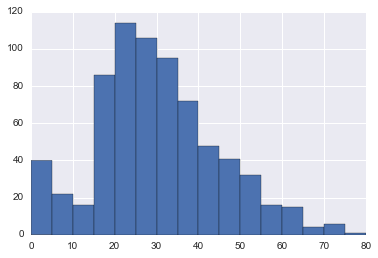

In [8]:
# Age_fill: Age and missing age data into new column
print 'Mean: ', train['Age'].mean()
print 'Median: ', train['Age'].median()
train.Age.hist(figsize=(6,4), bins=range(0,81,5));

train['AgeFill'] = train['Age']
test['AgeFill'] = test['Age']

age_map_df = train[['Gender', 'Pclass', 'Age']].groupby(['Gender', 'Pclass']).median().unstack()
print age_map_df

for i in range(0, 2):
    for j in range(0, 3):
        train.loc[(train.Age.isnull()) & (train.Gender == i) & (train.Pclass == j+1), 'AgeFill'] = age_map_df.ix[i,j]
        test.loc[(test.Age.isnull()) & (test.Gender == i) & (test.Pclass == j+1), 'AgeFill'] = age_map_df.ix[i,j]

In [9]:
# AgeIsNull: Whether age was missing or not (1=missing)
train['AgeIsNull'] = pd.isnull(train.Age).astype(int)
test['AgeIsNull'] = pd.isnull(test.Age).astype(int)

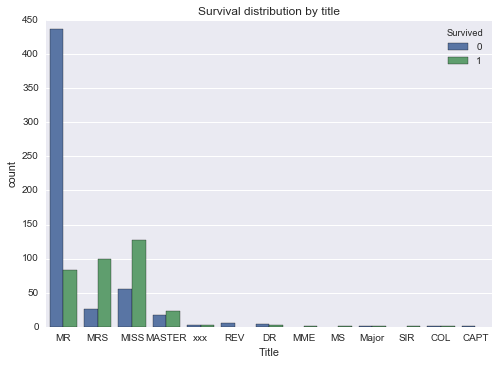

In [10]:
# Title column
train.loc[train['Name'].str.contains('Mr. ')==True, 'Title'] = 'MR' 
train.loc[train['Name'].str.contains('Ms. ')==True, 'Title'] = 'MS' 
train.loc[train['Name'].str.contains('Mrs. ')==True, 'Title'] = 'MRS' 
train.loc[train['Name'].str.contains('Miss. ')==True, 'Title'] = 'MISS' 
train.loc[train['Name'].str.contains('Master. ')==True, 'Title'] = 'MASTER' 
train.loc[train['Name'].str.contains('Rev. ')==True, 'Title'] = 'REV' 
train.loc[train['Name'].str.contains('Dr. ')==True, 'Title'] = 'DR' 
train.loc[train['Name'].str.contains('Mme. ')==True, 'Title'] = 'MME' 
train.loc[train['Name'].str.contains('Major. ')==True, 'Title'] = 'Major' 
train.loc[train['Name'].str.contains('Sir. ')==True, 'Title'] = 'SIR' 
train.loc[train['Name'].str.contains('Col. ')==True, 'Title'] = 'COL' 
train.loc[train['Name'].str.contains('Capt. ')==True, 'Title'] = 'CAPT' 

test.loc[test['Name'].str.contains('Mr. ')==True, 'Title'] = 'MR' 
test.loc[test['Name'].str.contains('Ms. ')==True, 'Title'] = 'MS' 
test.loc[test['Name'].str.contains('Mrs. ')==True, 'Title'] = 'MRS' 
test.loc[test['Name'].str.contains('Miss. ')==True, 'Title'] = 'MISS' 
test.loc[test['Name'].str.contains('Master. ')==True, 'Title'] = 'MASTER' 
test.loc[test['Name'].str.contains('Rev. ')==True, 'Title'] = 'REV' 
test.loc[test['Name'].str.contains('Dr. ')==True, 'Title'] = 'DR' 
test.loc[test['Name'].str.contains('Mme. ')==True, 'Title'] = 'MME' 
test.loc[test['Name'].str.contains('Major. ')==True, 'Title'] = 'Major' 
test.loc[test['Name'].str.contains('Sir. ')==True, 'Title'] = 'SIR' 
test.loc[test['Name'].str.contains('Col. ')==True, 'Title'] = 'COL' 
test.loc[test['Name'].str.contains('Capt. ')==True, 'Title'] = 'CAPT' 

train.Title.fillna('xxx', inplace=True) 
test.Title.fillna('xxx', inplace=True) 

# Title to number mapping
train['Title_num'] = train['Title'].map( {'xxx': -1, 'MR': 0, 'MS': 1, 'MRS': 2, 'MISS': 3, 'MASTER': 4, 'REV': 5, 'DR': 6, 'MME': 7, 'Major': 8, 'SIR': 9, 'COL': 10, 'CAPT': 11} ).astype(int)
test['Title_num'] = test['Title'].map( {'xxx': -1, 'MR': 0, 'MS': 1, 'MRS': 2, 'MISS': 3, 'MASTER': 4, 'REV': 5, 'DR': 6, 'MME': 7, 'Major': 8, 'SIR': 9, 'COL': 10, 'CAPT': 11} ).astype(int)

sns.countplot(x='Title', data=train[['Title', 'Survived']], hue='Survived')
#sns.countplot(x='Title', data=test[['Title']], color='g')
plt.title('Survival distribution by title');

In [11]:
# Filling up missing 'Fare' value

#test.ix[test.isnull().any(axis=1)]
for i in range(1, 4):
    test.loc[test.Fare.isnull() & test.Pclass==i,'Fare'] = test.groupby('Pclass').mean()['Fare'][i].round()

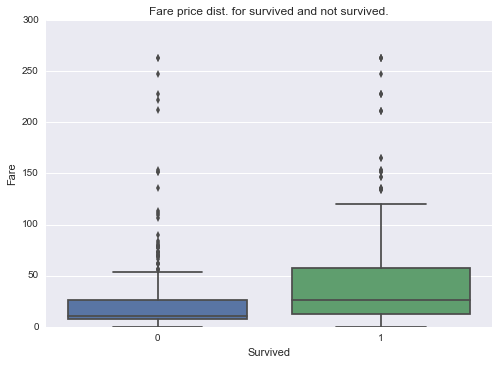

In [12]:
fig, ax1 = plt.subplots(1,1)
sns.boxplot(x='Survived', y='Fare', data=train[['Fare', 'Survived', 'Gender']],ax=ax1)
plt.title('Fare price dist. for survived and not survived.')
ax1.set_ylim([0,300]);

## Feature Engineering

In [13]:
# FamilySize
train['FamilySize'] = train['SibSp'] + train['Parch']
test['FamilySize'] = test['SibSp'] + test['Parch']

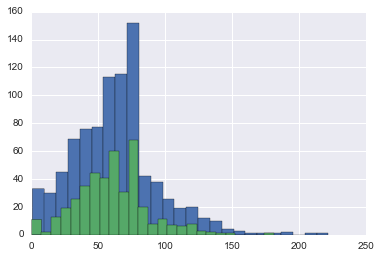

In [14]:
# Age*Class
train['Age*Class'] = train.AgeFill * train.Pclass
test['Age*Class'] = test.AgeFill * test.Pclass

train['Age*Class'].hist(bins=25, figsize=(6,4))
test['Age*Class'].hist(bins=25, figsize=(6,4));

## Non-numeric columns removal

In [15]:
train.dtypes[train.dtypes.map(lambda x: x=='object')]
test.dtypes[test.dtypes.map(lambda x: x=='object')]

train.dtypes[train.dtypes.map(lambda x: x=='object')].index
test.dtypes[test.dtypes.map(lambda x: x=='object')].index

# count NaN values
train.isnull().sum()

train.drop([u'PassengerId', u'Age', u'Name', u'Sex', u'Ticket', u'Cabin', u'Embarked', u'Title'], axis=1, inplace=True)
test.drop([u'PassengerId', u'Age', u'Name', u'Sex', u'Ticket', u'Cabin', u'Embarked', u'Title'], axis=1, inplace=True)

In [16]:
# Remove remaining recoords with NaN values 
print 'Train - number of NaNs: ',  len(train) - len(train.dropna())
train.dropna(inplace=True)

Train - number of NaNs:  2


In [17]:
# Are there any NaN values in Test set?
print 'Test set - number of NaNs: ',  len(test) - len(test.dropna())

Test set - number of NaNs:  0


In [18]:
# Scikit-learn needs arrays
train_data = train.values
test_data = test.values

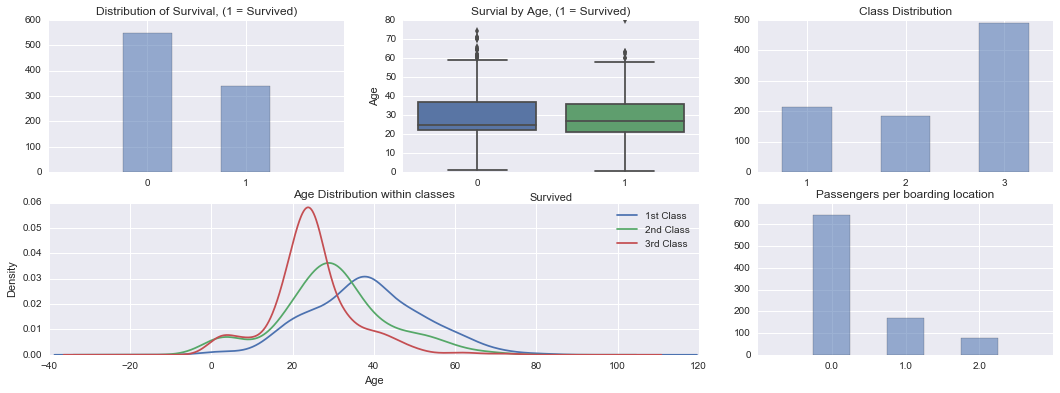

In [19]:
# Data visualization

# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,6), dpi=1600) 
alpha=alpha_scatterplot = 0.1 
alpha_bar_chart = 0.55

# lets us plot many diffrent shaped graphs together 
ax1 = plt.subplot2grid((2,3),(0,0))
# plots a bar graph of those who surived vs those who did not. 
train.Survived.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
# this nicely sets the margins in matplotlib to deal with a recent bug 1.3.1
ax1.set_xlim(-1, 2)
plt.xticks(rotation=0)
# puts a title on our graph
plt.title("Distribution of Survival, (1 = Survived)") 

plt.subplot2grid((2,3),(0,1))
sns.boxplot(x='Survived', y='AgeFill', data=train[['Survived', 'AgeFill']])
#plt.scatter(train.Survived, train.AgeFill, alpha=alpha_scatterplot)
# sets the y axis lablea
plt.ylabel("Age")
# formats the grid line style of our graphs 
plt.grid(b=True, which='major', axis='y') 
plt.title("Survial by Age, (1 = Survived)")

ax3 = plt.subplot2grid((2,3),(0,2))
train.Pclass.value_counts(sort=False).plot(kind="bar", alpha=alpha_bar_chart)
plt.xticks(rotation=0)
plt.title("Class Distribution")

ax4 = plt.subplot2grid((2,3),(1,0), colspan=2)
# plots a kernel desnsity estimate of the subset of the 1st class passanges's age
train.AgeFill[train.Pclass == 1].plot(kind='kde', ax=ax4) 
train.AgeFill[train.Pclass == 2].plot(kind='kde', ax=ax4)
train.AgeFill[train.Pclass == 3].plot(kind='kde', ax=ax4)
# plots an axis lable
ax4.set_xlabel("Age") 
plt.title("Age Distribution within classes")
# sets our legend for our graph.
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') 

ax5 = plt.subplot2grid((2,3),(1,2))
train.Port_no.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
ax5.set_xlim(-1, len(train.Port_no.value_counts()))
plt.xticks(rotation=0)
# specifies the parameters of our graphs
plt.title("Passengers per boarding location");

# Data Transformations

In [20]:
from sklearn import cross_validation

In [21]:
# Change the column's order
train_nona = train[['Pclass',
 'SibSp',
 'Parch',
 'Fare',
 'Gender',
 'Port_no',
 'AgeFill',
 'AgeIsNull',
 'Title_num',
 'FamilySize',
 'Age*Class', 
 'Survived']].dropna().copy()
train_data = train_nona.values

# Classifications

## SMV (Support Vector Machine)

In [22]:
from sklearn import svm

In [23]:
# Using Grid Search to find best classificator's parameters

from sklearn import grid_search
svr = svm.SVC(cache_size=2000) 

In [25]:
%%time

########## not normalized data ########

param_grid = [
  {'kernel': ['linear'], 'C': [0.01, 0.1, 1, 10, 100, 1000, 10000]},
  {'kernel': ['rbf'], 'C': [0.1, 0.01, 1, 10, 100, 1000, 10000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
 ]


## uwaga, cv zmienic na 15. zajmuje to ok 4,5 h.
clf_svm = grid_search.GridSearchCV(svr, param_grid, cv=3)

clf_svm.fit(train_data[:,:-1], np.reshape(train_data[:,-1:], (1, len(train_data)))[0])


Wall time: 41min 5s


In [26]:
# Results:
print 'Best score: ', clf_svm.best_score_, ', using metric: ', clf_svm.scorer_.func_name
print 'Best parameters: ', clf_svm.best_params_
print 'Best estimator: ', clf_svm.best_estimator_

Best score:  0.814398200225 , using metric:  _passthrough_scorer
Best parameters:  {'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}
Best estimator:  SVC(C=1000, cache_size=2000, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [27]:
clf_svm_df = pd.concat([pd.DataFrame(pd.DataFrame(clf_svm.grid_scores_).parameters.tolist())
           ,pd.DataFrame(clf_svm.grid_scores_).drop(['parameters', 'cv_validation_scores'], axis=1)],axis=1)

clf_svm_df['NORM']=False

In [28]:
%%time

########## normalized data ############

from sklearn import preprocessing

# L2 normalization. Normalize each feature so remember to normalize along axis=0. SVM based on normalized data is many times faster!
train_data_norm = preprocessing.normalize(train_data, norm='l2', axis=0).astype(float).round(2)
#X_test_norm = preprocessing.normalize(X_test, norm='l2', axis=0).astype(float).round(2)

param_grid = [
  {'kernel': ['linear'], 'C': [0.01, 0.1, 1, 10, 100, 1000, 10000]},
  {'kernel': ['rbf'], 'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
 ]

clf_svm_norm = grid_search.GridSearchCV(svr, param_grid, cv=15)

clf_svm_norm.fit(train_data[:,:-1], np.reshape(train_data[:,-1:], (1, len(train_data)))[0])

# Results:
print 'Best score: ', clf_svm_norm.best_score_, ', using metric: ', clf_svm_norm.scorer_.func_name
print 'Best parameters: ', clf_svm_norm.best_params_
print 'Best estimator: ', clf_svm_norm.best_estimator_


clf_svm_df_norm = pd.concat([pd.DataFrame(pd.DataFrame(clf_svm_norm.grid_scores_).parameters.tolist())
           ,pd.DataFrame(clf_svm_norm.grid_scores_).drop(['parameters', 'cv_validation_scores'],axis=1)
          ],axis=1)

clf_svm_df_norm['NORM']=True

clf_svm_df = clf_svm_df.append(clf_svm_df_norm, ignore_index=True)

print clf_svm_df

Best score:  0.823397075366 , using metric:  _passthrough_scorer
Best parameters:  {'kernel': 'rbf', 'C': 10000, 'gamma': 0.0001}
Best estimator:  SVC(C=10000, cache_size=2000, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
           C    gamma  kernel  mean_validation_score   NORM
0       0.01      NaN  linear               0.791901  False
1       0.10      NaN  linear               0.788526  False
2       1.00      NaN  linear               0.785152  False
3      10.00      NaN  linear               0.784027  False
4     100.00      NaN  linear               0.797525  False
5    1000.00      NaN  linear               0.799775  False
6   10000.00      NaN  linear               0.797525  False
7       0.10   0.0001     rbf               0.670416  False
8       0.10   0.0010     rbf               0.676040  False
9       0.10   0.0100     

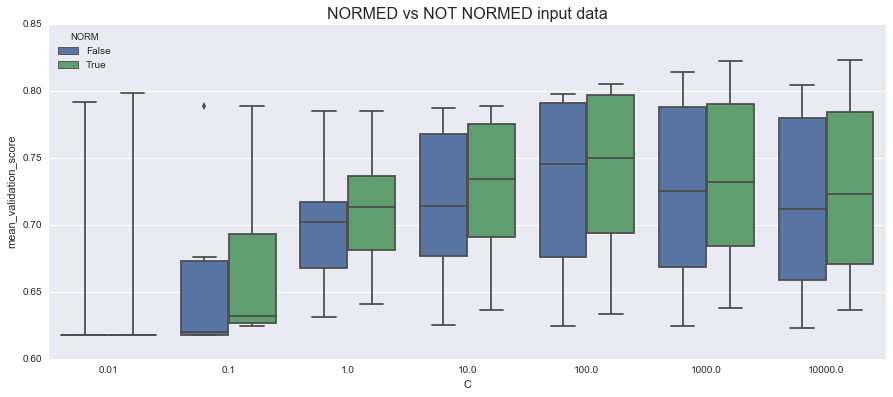

In [29]:
fi,ax1=plt.subplots(figsize=(15,6))
sns.boxplot(x='C', y='mean_validation_score', hue=('NORM'), data=clf_svm_df)
plt.title('NORMED vs NOT NORMED input data',size=16);

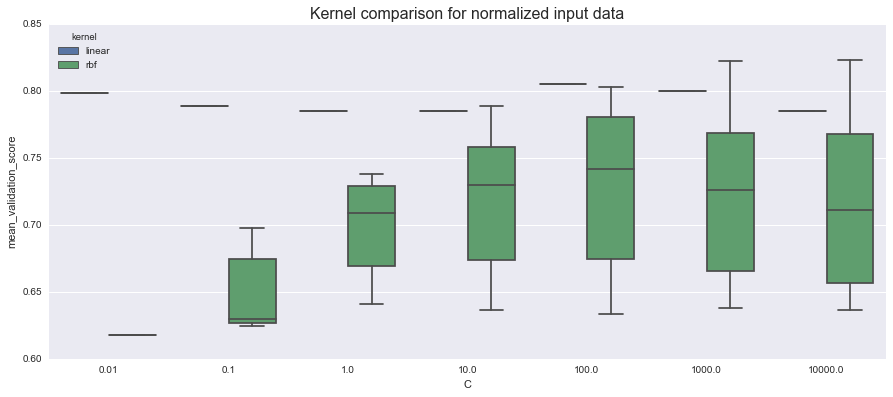

In [30]:
fi,ax1=plt.subplots(figsize=(15,6))
sns.boxplot(x='C', y='mean_validation_score', hue=('kernel'), data=clf_svm_df.ix[((clf_svm_df['NORM']==True))])
#sns.boxplot(x='C', y='mean_validation_score', hue=('kernel'), data=clf_svm_df.ix[clf_svm_df.NORM==False])
plt.title('Kernel comparison for normalized input data',size=16);

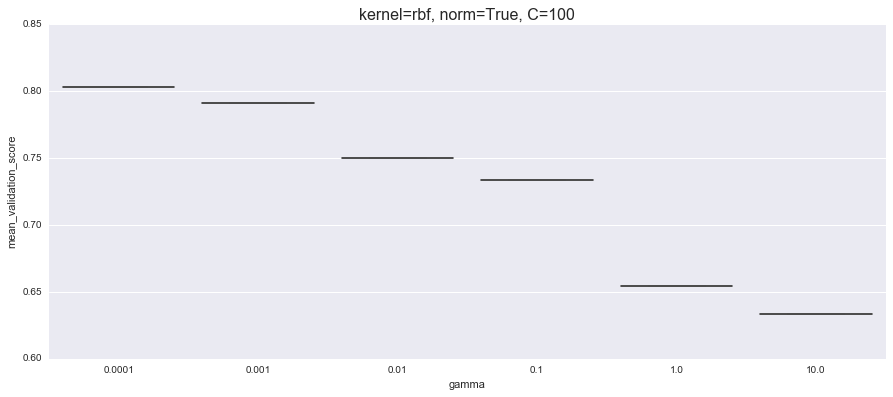

In [31]:
fi,ax1=plt.subplots(figsize=(15,6))
sns.boxplot(x='gamma', y='mean_validation_score', data=clf_svm_df.ix[((clf_svm_df['NORM']==True)
                                                                      & (clf_svm_df['kernel']=='rbf')
                                                                      & (clf_svm_df['C']==100)
                                                                     )])
#sns.boxplot(x='C', y='mean_validation_score', hue=('kernel'), data=clf_svm_df.ix[clf_svm_df.NORM==False])
plt.title('kernel=rbf, norm=True, C=100',size=16);

In [32]:
# best results

clf_svm_df.sort_values('mean_validation_score', ascending=False)[:5]

          C   gamma  kernel  mean_validation_score   NORM
92  10000.0  0.0001     rbf               0.823397   True
86   1000.0  0.0001     rbf               0.822272   True
37   1000.0  0.0001     rbf               0.814398  False
53    100.0     NaN  linear               0.805399   True
43  10000.0  0.0001     rbf               0.804274  False

In [33]:
# params for best score C=10, kernel=rbf, NORM=True

clf_svm_df.ix[((clf_svm_df['C']==100) & (clf_svm_df['NORM']==True) & (clf_svm_df['kernel']=='rbf'))].sort_values('mean_validation_score', ascending=False)#.plot()

        C    gamma kernel  mean_validation_score  NORM
80  100.0   0.0001    rbf               0.803150  True
81  100.0   0.0010    rbf               0.790776  True
82  100.0   0.0100    rbf               0.750281  True
83  100.0   0.1000    rbf               0.733408  True
84  100.0   1.0000    rbf               0.654668  True
85  100.0  10.0000    rbf               0.633296  True

In [34]:
norm_comp = clf_svm_df.set_index(['C', 'gamma', 'kernel', 'NORM']).unstack().reset_index()
norm_comp[('mean_validation_score', 'diff')] =  ((norm_comp[('mean_validation_score', False)] - norm_comp[('mean_validation_score', True)])*1.0).round(2)
print norm_comp.sort_values(('mean_validation_score', True), ascending=False)

             C    gamma  kernel mean_validation_score                
NORM                                            False      True  diff
43    10000.00   0.0001     rbf              0.804274  0.823397 -0.02
36     1000.00   0.0001     rbf              0.814398  0.822272 -0.01
28      100.00      NaN  linear              0.797525  0.805399 -0.01
29      100.00   0.0001     rbf              0.795276  0.803150 -0.01
35     1000.00      NaN  linear              0.799775  0.799775  0.00
0         0.01      NaN  linear              0.791901  0.798650 -0.01
30      100.00   0.0010     rbf              0.787402  0.790776  0.00
7         0.10      NaN  linear              0.788526  0.788526  0.00
23       10.00   0.0010     rbf              0.787402  0.788526  0.00
14        1.00      NaN  linear              0.785152  0.785152  0.00
..         ...      ...     ...                   ...       ...   ...
10        0.10   0.0100     rbf              0.619798  0.632171 -0.01
13        0.10  10.0

## DecisionTreeClassifier

In [35]:
cv_folds = [3,5,10,15]

In [36]:
%%time

import sklearn.tree as tree

min_samples_split = range(2,110,10)
min_samples_leaf = range(1,110,10)
max_depth = range(1,110,10) + [None]

parameters = {'criterion':('gini', 'entropy'), 
              'min_samples_split':min_samples_split, 
              'min_samples_leaf':min_samples_leaf,
              'max_depth': max_depth 
             }

for i in range(len(cv_folds)):
    clf_dt = tree.DecisionTreeClassifier()
    clf_dt = grid_search.GridSearchCV(clf_dt, parameters, cv=cv_folds[i])
    clf_dt.fit(train_data[:,:-1], np.reshape(train_data[:,-1:], (1, len(train_data)))[0])

    # Results:
    print 'CV: ', cv_folds[i]
    print 'Best score: ', clf_dt.best_score_, ', using metric: ', clf_dt.scorer_.func_name
    print 'Best parameters: ', clf_dt.best_params_
    print 'Best estimator: ', clf_dt.best_estimator_

CV:  3
Best score:  0.817772778403 , using metric:  _passthrough_scorer
Best parameters:  {'min_samples_split': 32, 'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 11}
Best estimator:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=11,
            min_samples_split=32, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
CV:  5
Best score:  0.820022497188 , using metric:  _passthrough_scorer
Best parameters:  {'min_samples_split': 42, 'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 1}
Best estimator:  DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=11,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=42, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
CV:  10
Best score:  0.820022497188 , using metric:  _pass

          mean criterion  max_depth  min_samples_leaf  min_samples_split
1227  0.821147      gini      101.0                11                 62
1348  0.821147      gini        NaN                11                 62
138   0.821147      gini       11.0                11                 62
380   0.820022      gini       31.0                11                 62
2679  0.820022   entropy      101.0                11                 62


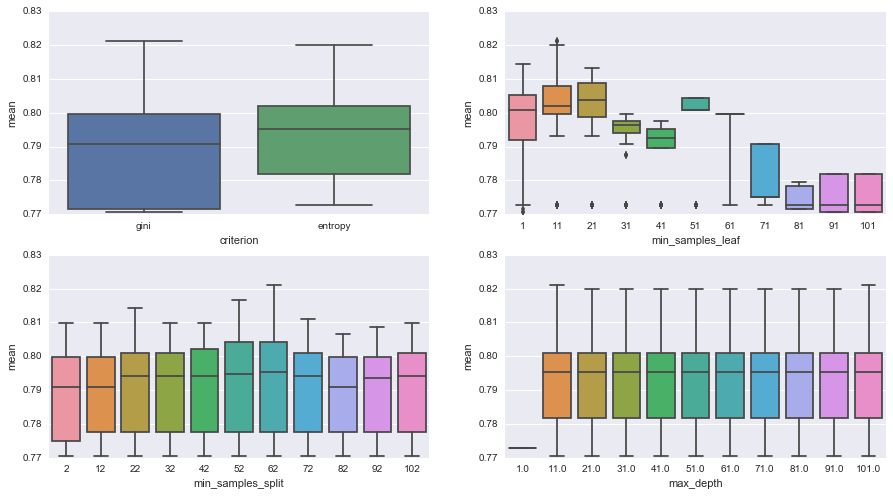

In [37]:
clf_dt_df = pd.concat([pd.DataFrame(clf_dt.grid_scores_, columns=['parameters', 'mean', 'cv_val_score']).drop(['parameters', 'cv_val_score'], axis=1),
           pd.DataFrame(pd.DataFrame(clf_dt.grid_scores_, columns=['parameters', 'mean', 'cv_val_score']).parameters.tolist())],
           axis=1
         )

print clf_dt_df.sort_values('mean', ascending=False)[:5]

fig, ((axis1,axis2),(axis3,axis4)) = plt.subplots(2,2,figsize=(15,8))
sns.boxplot(x='criterion', y='mean', data=clf_dt_df, ax=axis1)
sns.boxplot(x='min_samples_leaf', y='mean', data=clf_dt_df, ax=axis2)
sns.boxplot(x='min_samples_split', y='mean', data=clf_dt_df, ax=axis3)
sns.boxplot(x='max_depth', y='mean', data=clf_dt_df, ax=axis4);

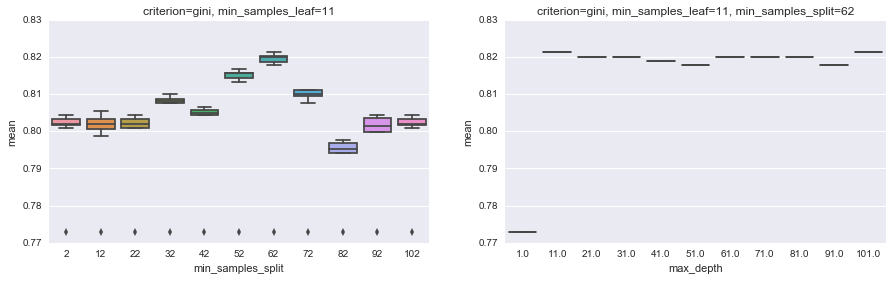

In [38]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.boxplot(x='min_samples_split', y='mean', data=clf_dt_df.ix[((clf_dt_df['criterion']=='gini') 
                                                               & (clf_dt_df['min_samples_leaf']==11))
                                                               ], ax = axis1)
axis1.set_title('criterion=gini, min_samples_leaf=11')

sns.boxplot(x='max_depth', y='mean', data=clf_dt_df.ix[((clf_dt_df['criterion']=='gini') 
                                                               & (clf_dt_df['min_samples_leaf']==11))
                                                              & (clf_dt_df['min_samples_split']==62)
                                                              ], ax = axis2)
axis2.set_title('criterion=gini, min_samples_leaf=11, min_samples_split=62');


In [39]:
# tree visualization
#from sklearn.externals.six import StringIO  
#from IPython.display import Image
#import pydot 
#dot_data = StringIO()
#tree.export_graphviz(clf_dt.best_estimator_, out_file=dot_data, 
#                     feature_names=train.columns.tolist(), 
#                     class_names=['Not Survived','Survived'], 
#                     filled=True, 
#                     rounded=True,                           
#                     special_characters=True)
#graph = pydot.graph_from_dot_data(dot_data.getvalue())
#Image(graph.create_png())

## ExtraTreesClassifier

In [40]:
%%time
from sklearn.ensemble import ExtraTreesClassifier
clf_et = ExtraTreesClassifier()

clf_et.get_params().keys()
max_depth = range(1, 110, 10) + [None]
n_estimators = range(1, 110, 10)
min_samples_split = range(2, 31, 10)
min_samples_leaf = range(1, 31, 10)


parameters = {'criterion': ('gini', 'entropy'), 
              'n_estimators': n_estimators, 
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

for i in range(len(cv_folds)):
    clf_et = ExtraTreesClassifier()
    clf_et = grid_search.GridSearchCV(clf_et, parameters, cv=cv_folds[i])
    clf_et.fit(train_data[:,:-1], np.reshape(train_data[:,-1:], (1, len(train_data)))[0])

    # Results:
    print 'CV: ', cv_folds[i]
    print 'Best score: ', clf_et.best_score_, ', using metric: ', clf_et.scorer_.func_name
    print 'Best parameters: ', clf_et.best_params_
    print 'Best estimator: ', clf_et.best_estimator_

CV:  3
Best score:  0.836895388076 , using metric:  _passthrough_scorer
Best parameters:  {'min_samples_split': 22, 'n_estimators': 71, 'criterion': 'gini', 'max_depth': 91, 'min_samples_leaf': 1}
Best estimator:  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=91, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=22,
           min_weight_fraction_leaf=0.0, n_estimators=71, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
CV:  5
Best score:  0.839145106862 , using metric:  _passthrough_scorer
Best parameters:  {'min_samples_split': 12, 'n_estimators': 21, 'criterion': 'gini', 'max_depth': 101, 'min_samples_leaf': 1}
Best estimator:  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=101, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=12,
           min_weight_fraction_leaf=

In [41]:
clf_et_df = pd.concat([pd.DataFrame(clf_et.grid_scores_, columns=['parameters', 'mean', 'cv_val_score']).drop(['parameters', 'cv_val_score'], axis=1),
           pd.DataFrame(pd.DataFrame(clf_et.grid_scores_, columns=['parameters', 'mean', 'cv_val_score']).parameters.tolist())],
           axis=1
         )

print clf_et_df.sort_values('mean', ascending=False)[:5]

          mean criterion  max_depth  min_samples_leaf  min_samples_split  \
2297  0.843645   entropy        NaN                 1                 12   
1901  0.841395   entropy       71.0                 1                 12   
1503  0.840270   entropy       31.0                 1                 12   
1992  0.840270   entropy       81.0                 1                 12   
612   0.839145      gini       61.0                 1                 12   

      n_estimators  
2297            91  
1901            91  
1503            71  
1992            11  
612             71  


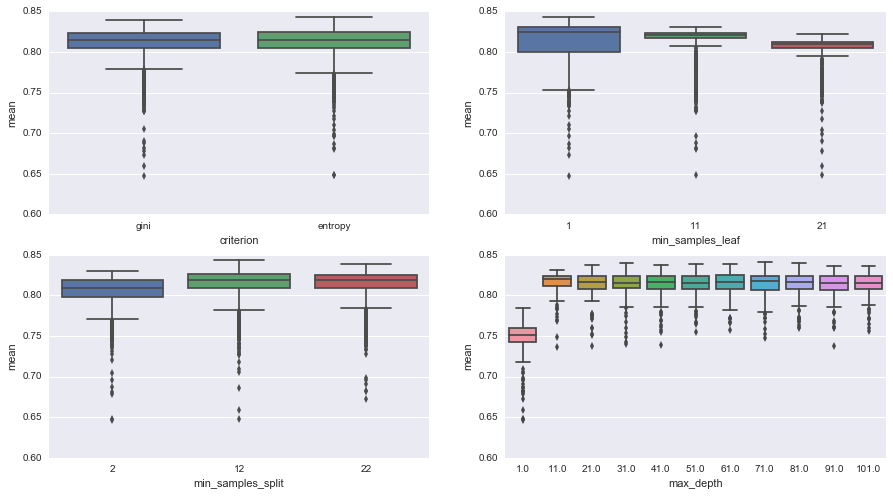

In [42]:
fig, ((axis1,axis2),(axis3,axis4)) = plt.subplots(2,2,figsize=(15,8))
sns.boxplot(x='criterion', y='mean', data=clf_et_df, ax=axis1)
sns.boxplot(x='min_samples_leaf', y='mean', data=clf_et_df, ax=axis2)
sns.boxplot(x='min_samples_split', y='mean', data=clf_et_df, ax=axis3)
sns.boxplot(x='max_depth', y='mean', data=clf_et_df, ax=axis4);

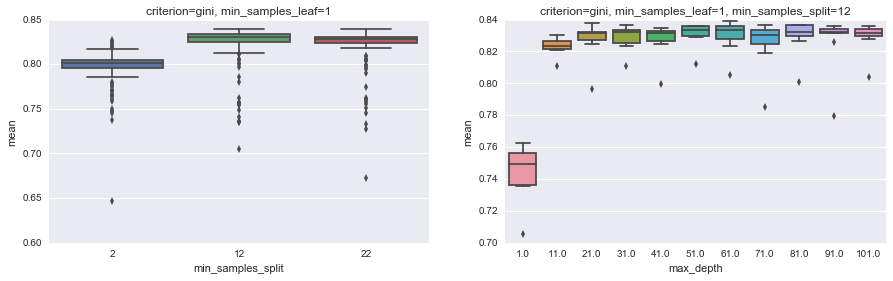

In [43]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.boxplot(x='min_samples_split', y='mean', data=clf_et_df.ix[((clf_et_df['criterion']=='gini') 
                                                               & (clf_et_df['min_samples_leaf']==1))
                                                               ], ax = axis1)
axis1.set_title('criterion=gini, min_samples_leaf=1')

sns.boxplot(x='max_depth', y='mean', data=clf_et_df.ix[((clf_et_df['criterion']=='gini') 
                                                               & (clf_et_df['min_samples_leaf']==1))
                                                              & (clf_et_df['min_samples_split']==12)
                                                              ], ax = axis2)
axis2.set_title('criterion=gini, min_samples_leaf=1, min_samples_split=12');

I'm afraid, that min_samples_leaf=1 may cause the **overfitting**. If this is true, how to choose the best params, if that settings give the best scores?

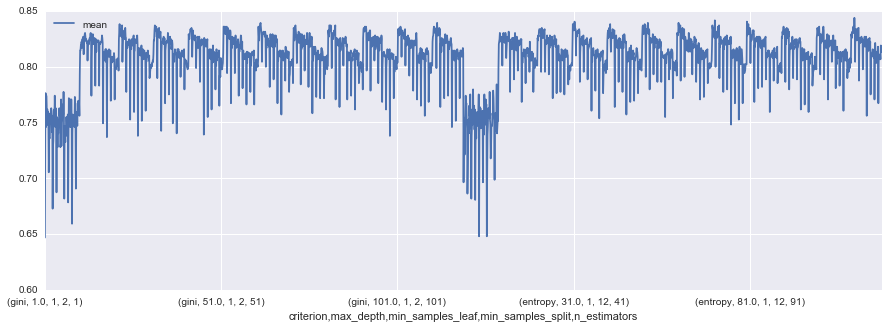

In [44]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5)) 
clf_et_df.set_index(['criterion', u'max_depth', u'min_samples_leaf',
       u'min_samples_split', u'n_estimators']).plot(ax=ax1);

## Random Forest

In [45]:
%%time

from sklearn.ensemble import RandomForestClassifier

n_estimators = range(1,110,10)
min_samples_split = range(2,110,10)
min_samples_leaf = range(1,110,10)

parameters = {'criterion':('gini', 'entropy'), 
              'n_estimators':n_estimators, 
              'min_samples_split':min_samples_split, 
              'min_samples_leaf':min_samples_leaf}


for i in range(len(cv_folds)):
    clf_rf = RandomForestClassifier()
    # clf.get_params()
    clf_rf = grid_search.GridSearchCV(clf_rf, parameters, cv = cv_folds[i]) 
    clf_rf.fit(train_data[:,:-1], np.reshape(train_data[:,-1:], (1, len(train_data)))[0])

    # Results:
    print 'CV: ', cv_folds[i]
    print 'Best score: ', clf_rf.best_score_, ', using metric: ', clf_rf.scorer_.func_name
    print 'Best parameters: ', clf_rf.best_params_
    print 'Best estimator: ', clf_rf.best_estimator_

CV:  3
Best score:  0.842519685039 , using metric:  _passthrough_scorer
Best parameters:  {'min_samples_split': 12, 'n_estimators': 21, 'criterion': 'gini', 'min_samples_leaf': 1}
Best estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=12,
            min_weight_fraction_leaf=0.0, n_estimators=21, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
CV:  5
Best score:  0.835770528684 , using metric:  _passthrough_scorer
Best parameters:  {'min_samples_split': 72, 'n_estimators': 71, 'criterion': 'gini', 'min_samples_leaf': 21}
Best estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=21, min_samples_split=72,
            min_weight_fraction_leaf=0.0, n_es

In [46]:
clf_rf_df = pd.concat([pd.DataFrame(clf_rf.grid_scores_, columns=['parameters', 'mean', 'cv_val_score']).drop(['parameters', 'cv_val_score'], axis=1),
           pd.DataFrame(pd.DataFrame(clf_rf.grid_scores_, columns=['parameters', 'mean', 'cv_val_score']).parameters.tolist())],
           axis=1
         )

print clf_rf_df.sort_values('mean', ascending=False)[:5]

          mean criterion  min_samples_leaf  min_samples_split  n_estimators
26    0.842520      gini                 1                 22            41
1358  0.838020   entropy                 1                 22            51
28    0.838020      gini                 1                 22            61
20    0.838020      gini                 1                 12            91
1362  0.836895   entropy                 1                 22            91


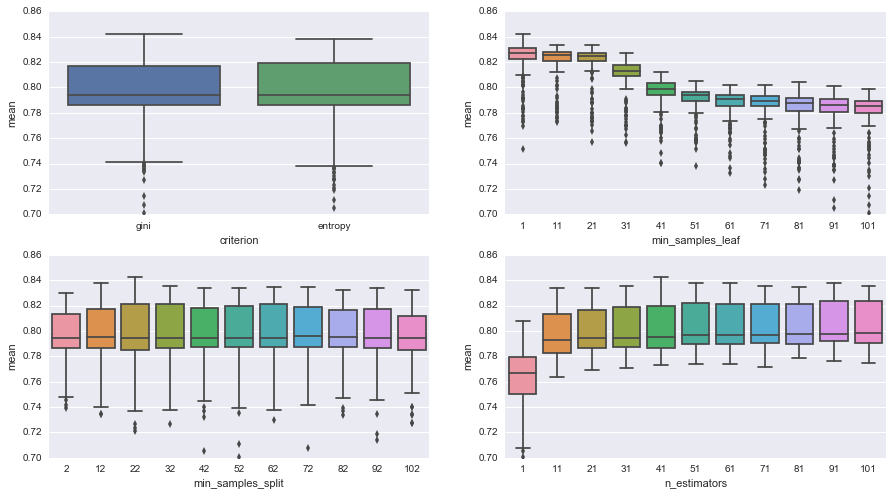

In [47]:
fig, ((axis1,axis2),(axis3,axis4)) = plt.subplots(2,2,figsize=(15,8))
sns.boxplot(x='criterion', y='mean', data=clf_rf_df, ax=axis1)
sns.boxplot(x='min_samples_leaf', y='mean', data=clf_rf_df, ax=axis2)
sns.boxplot(x='min_samples_split', y='mean', data=clf_rf_df, ax=axis3)
sns.boxplot(x='n_estimators', y='mean', data=clf_rf_df, ax=axis4);

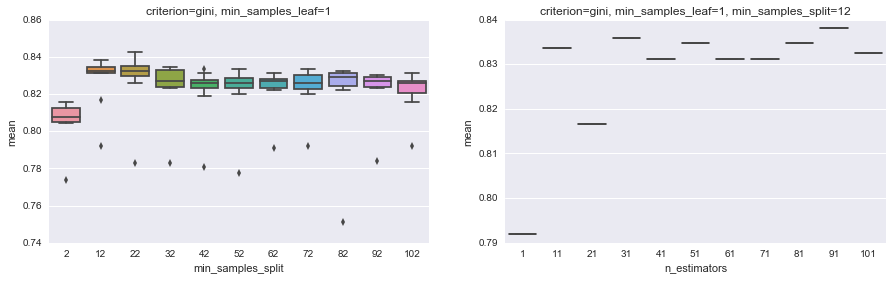

In [48]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.boxplot(x='min_samples_split', y='mean', data=clf_rf_df.ix[((clf_rf_df['criterion']=='gini') 
                                                               & (clf_rf_df['min_samples_leaf']==1))
                                                               ], ax = axis1)
axis1.set_title('criterion=gini, min_samples_leaf=1')

sns.boxplot(x='n_estimators', y='mean', data=clf_rf_df.ix[((clf_rf_df['criterion']=='gini') 
                                                               & (clf_rf_df['min_samples_leaf']==1))
                                                              & (clf_rf_df['min_samples_split']==12)
                                                              ], ax = axis2)
axis2.set_title('criterion=gini, min_samples_leaf=1, min_samples_split=12');

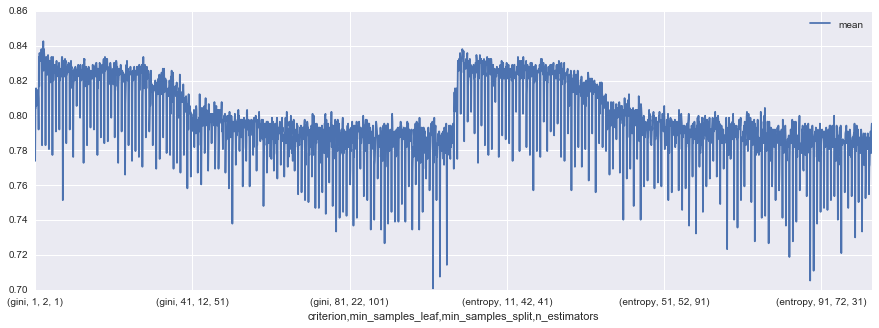

In [49]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5)) 
clf_rf_df.set_index(['criterion', u'min_samples_leaf', u'min_samples_split', u'n_estimators']).plot(ax=ax1);

# Sumarry and export

In [62]:
print 'RESULTS: '
print '   SVC:             ', clf_svm.best_score_.round(4), ' Kaggle result:   0.76077'
print '   SVC (norm data): ', clf_svm_norm.best_score_.round(4), ' Kaggle result:   0.75120'
print '   Decision Tree:   ', clf_dt.best_score_.round(4), ' Kaggle result:   0.77512'
print '   Extra Tree:      ', clf_et.best_score_.round(4), ' Kaggle result:   0.76555'
print '   Random Forest    ', clf_rf.best_score_.round(4), ' Kaggle result:   0.79426'

RESULTS: 
   SVC:              0.8144  Kaggle result:   0.76077
   SVC (norm data):  0.8234  Kaggle result:   0.75120
   Decision Tree:    0.8211  Kaggle result:   0.77512
   Extra Tree:       0.8436  Kaggle result:   0.76555
   Random Forest     0.8425  Kaggle result:   0.79426


### BEST RESULT ON KAGGLE: Random Forest  (0.8425),  Kaggle result:   0.79426

In [60]:
# Test set predictions and saving results to file
# predictions_export(clf_rf.predict(test_data), 'Titanic_Results_v4_rf.csv')